<small>
Copyright (C) 2025, École Polytechnique Fédérale de Lausanne. All Rights Reserved.
</small>

---

# Model Predictive Control: Exercise 1

Consider the discrete-time LTI system defined by
$$
\begin{align*}
x_{i+1} &= Ax_i + Bu_i \\
y_i &= Cx_i
\end{align*}
$$
with
$$
A = \begin{bmatrix}
4/3 & -2/3 \\
1 & 0
\end{bmatrix}, \quad
B = \begin{bmatrix}
1 \\
0
\end{bmatrix}, \quad
C = \begin{bmatrix}
-2/3 & 1
\end{bmatrix}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# System dynamics
nx = 2
nu = 1
A = np.array([[4 / 3, -2 / 3], [1, 0]])
B = np.array([[1], [0]])
C = np.array([[-2 / 3, 1]])

Throughout this notebook, you will mainly use `numpy` and `matplolib`. If you are not familiar with these libraries, we encourage you to check out some basic guides such as the following ones:
- [NumPy for Matlab users](https://numpy.org/doc/stable/user/numpy-for-matlab-users.html): a good starting point for people familiar with Matlab. You will see that NumPy and Matlab resemble each other but do have some differences.
- [NumPy fundamentals](https://numpy.org/doc/stable/user/basics.html): a more exhaustive guide that can be a useful resource beyond this course. You should not feel obligated to read all of it at once. We recommend rather going there to complement your knowledge on a specific topic when you need it.
- [Basic Matplotlib](https://www.w3schools.com/python/matplotlib_intro.asp): simple examples to show you the basic functionality of Matplotlib. If you are used to Matlab plotting

Note that all the functions you should need are already imported at the beginning of this notebook, you can use them directly.

## Problem 1: Bellman recursion

Consider the optimal control law minimizing the cost
$$ V = \sum_{i=0}^{N-1} (x_i^T Q x_i + u_i^T R u_i) + x_N^T P_f x_N$$
with 
$$ Q = C^T C + 0.001 I_{2\times 2}, \quad R = 0.001, \quad P_f = Q\,.$$

### Task 1

Use the discrete-time Bellman recursion to define a function `bellman` that takes as input an integer `N` and outputs a list of arrays `Klist` containing the linear feedback gains to be applied at each stage `i` in the finite horizon.

> _Hint_: You can use the function `np.linalg.solve` to solve a linear system, the same way you would use `\` in Matlab.

In [3]:
Q = C.T @ C + 0.001 * np.eye(2)
R = np.array([[0.001]])

In [ ]:
def bellman(N: int)-> list[np.ndarray]:
    Klist = []

    H = Q
    for i in range(N - 1, -1, -1):
        K = -np.linalg.solve(R + B.T @ H @ B, B.T @ H @ A)
        H = Q + K.T @ R @ K + (A + B @ K).T @ H @ (A + B @ K)
        Klist.append(K)

    Klist = Klist[::-1]
    return Klist

[array([[-0.02560941,  0.66536146]]), array([[0.07236914, 0.66526359]]), array([[0.12574711, 0.66521028]]), array([[0.15180702, 0.66518425]]), array([[0.16293347, 0.66517339]])]


# Problem 2: Receding horizon control

### Task 1

Compute the open-loop prediction given by the optimal control law computed you computed above at the state $x=[10, 10]^T$. Compute the closed-loop state trajectory over 20 time steps, starting from the same initial state. 

In [39]:
# Initial condition
x0 = np.array([[10], [10]])
stable=False
N=0
while not stable:
    # Control gains
    N += 1 
    Klist = bellman(N)

    # Open-loop prediction
    x_ol = [x0]
    for i in range(N):
        u = Klist[i] @ x_ol[-1]
        x_ol.append(A@x_ol[-1]+B@u)
    x_ol = np.column_stack(x_ol)

    # Closed-loop control simulation
    K = Klist[0]
    # Checking if CL system is stable
    stable = not np.max(np.abs(np.linalg.eigvals(A + B @ K))) > 1
    #raise ValueError("System is unstable! Choose a longer horizon.")
print(f"Minimum N is {N}")
tmax = 20

x_cl = [x0]
for i in range(N):
    u = K @ x_cl[-1]
    x_cl.append(A@x_cl[-1]+B@u)
x_cl = np.column_stack(x_cl)


Minimum N is 7


### Task 2

Plot side by side the closed-loop trajectory and the open-loop prediction obtained from the first state. 

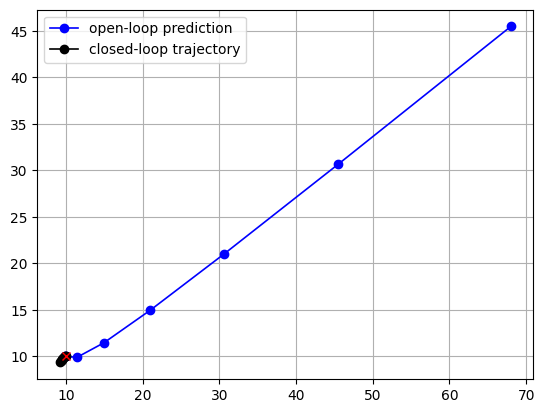

In [40]:
plt.plot(x0[0], x0[1], "rx", zorder=10)

plt.plot(x_ol[0,:],x_ol[1,:] , "b-o" , linewidth=1.2, label="open-loop prediction" )

plt.plot(x_cl[0, :], x_cl[1, :], "k-o", linewidth=1.2, label="closed-loop trajectory")

plt.grid(True)
plt.legend()
plt.show()

> **NOTE**:
> In the following three tasks, you should only modify some values in the code above, observe the results and make conclusions.

### Task 3

Use the code for the previous two questions to find the minimum horizon length $N^*$ that stabilizes the system.

### Task 4

Motivate why increasing the horizon stablizes the closed-loop system.

### Task 5

Given a horizon length $N^*$ that stabilizes the closed-loop system, can you be sure that the system will be stable for $N > N^*$?


# Problem 3: Linear Quadratic Regulator (LQR)

### Task 1

Implement the infinite horizon LQR controller $u = K_\infty x$.

> _Hint_: You can use the function [`dlqr`](https://python-control.readthedocs.io/en/0.10.2/generated/control.dlqr.html#control.dlqr) from the Python control toolbox (imported above). Note that this function uses a slightly different convention and computes a matrix $K_\infty$ such that the control to apply is $u = -K_\infty x$.

In [41]:
Kinf, Hinf, _ = ct.dlqr(A, B, Q, R)   
Kinf = - Kinf  

### Task 2

Compare the infinite horizon cost for the system in closed loop with $u = K_\infty x$ and with $u = K_{N^*} x$.

> _Hint_: For the latter, you can approximate the infinite horizon cost numerically using long state and input trajectories:
> $$
> V_\infty = \sum_{k=0}^{\infty} (x_k^T Q x_k + u_k^T R u_k) \approx \sum_{k=0}^{1000} (x_k^T Q x_k + u_k^T R u_k) 
> $$

In [42]:
cost_inf = (x0.T @ Hinf @ x0)[0,0]
print("Infinite horizon cost with u = Kinf @ x :", cost_inf)


tmax = 1000
x_cl = [x0]
x_cl2 = [x0]
u_cl = []
for t in range(tmax):
    u_cl.append(K @ x_cl[-1])
    x_cl.append(A @ x_cl[-1] + B @ u_cl[-1])
x_cl = np.column_stack(x_cl)
u_cl = np.column_stack(u_cl)

cost_fin = np.sum(x_cl*(Q @ x_cl)) +np.sum(u_cl*(R @ u_cl))
print("Infinite horizon cost with u = K @ x:", cost_fin)

Infinite horizon cost with u = Kinf @ x : 67.13447332994315
Infinite horizon cost with u = K @ x: 531.9050609406604
